<h1>Testing the E2E simulations</h1>

This script introduces the end-to-end (E2E) simulations that are used in "**calibration.py**", for the influence calibration of each individual segment. The testing of the script itself is done in this next notebook.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import webbpsf

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util
import image_pastis as impastis

# Path to all the outputs from "aperture_definition.py".
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
# Change into that directory
os.chdir(dir)

os.environ['WEBBPSF_PATH'] = CONFIG_INI.get('local', 'webbpsf_data_path')
print('Currenlty running on WebbPSF', webbpsf.version.version)

ModuleNotFoundError: No module named 'python'

In [ ]:
# Define some useful random functions

# This one is copied from util_pastis and could just as well be used as util.zoom_cen().
def zoom(im, bb):
    """
    Cut out a square box from the image center with half-box size bb.
    :param im: image from which box will be taken
    :param bb: half-box size
    :return:
    """
    x = int(im.shape[1]/2)
    y = int(im.shape[0]/2)
    return(im[y-bb:y+bb, x-bb:x+bb])

In [21]:
# Get some parameters
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')         # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')                       # filter
im_size_e2e = CONFIG_INI.getint('numerical', 'im_size_px_webbpsf')          # image size in pixels
wss_segs = webbpsf.constants.SEGNAMES_WSS_ORDER
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')

nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')    # [nm] amplitude of aberration
zern_number = CONFIG_INI.getint('calibration', 'zernike')               # Which (Noll) Zernike we are calibrating for
wss_zern_nb = util.noll_to_wss(zern_number)                             # Convert from Noll to WSS framework

For starters, lets completely independently create some WebbPSF images of a direct image (no coronagraph) and a coronagraphic image.

In [22]:
# Create two NIRCam objects
nc = webbpsf.NIRCam()
nc_coro = webbpsf.NIRCam()

In [23]:
# Btw:
print('NIRCam pixelscale:', nc.pixelscale)
print('Telescope:', nc.telescope)
print('nc name:', nc.name)
print('NIRCam module used:', nc.module)
print('NIRCam list of image masks:', nc.image_mask_list)
print('NIRCam list of pupil masks:', nc.pupil_mask_list)
print('NIRCam currently used OPD:', nc.pupilopd)
print('NIRCam detector list:', nc.detector_list)
print('nc used detector:', nc.detector)
print('Pixel position in (X, Y) on the detector:', nc.detector_position)
print('NIRCam filter list:', nc.filter_list)
print('nc used filter:', nc.filter)
print('nc channel used:', nc.channel)


NIRCam pixelscale: 0.0311
Telescope: JWST
nc name: NIRCam
NIRCam module used: A
NIRCam list of image masks: ['MASKLWB', 'MASKSWB', 'MASK210R', 'MASK335R', 'MASK430R']
NIRCam list of pupil masks: ['CIRCLYOT', 'WEDGELYOT', 'MASKRND', 'MASKSWB', 'MASKLWB', 'WEAK LENS +4', 'WEAK LENS +8', 'WEAK LENS -8', 'WEAK LENS +12 (=4+8)', 'WEAK LENS -4 (=4-8)', 'WLP4', 'WLM4', 'WLP8', 'WLM8', 'WLP12']
NIRCam currently used OPD: OPD_RevW_ote_for_NIRCam_requirements.fits.gz
NIRCam detector list: ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCA5', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4', 'NRCB5']
nc used detector: NRCA1
Pixel position in (X, Y) on the detector: (1024, 1024)
NIRCam filter list: ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']
nc used filter: F200W
nc channel used: short


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


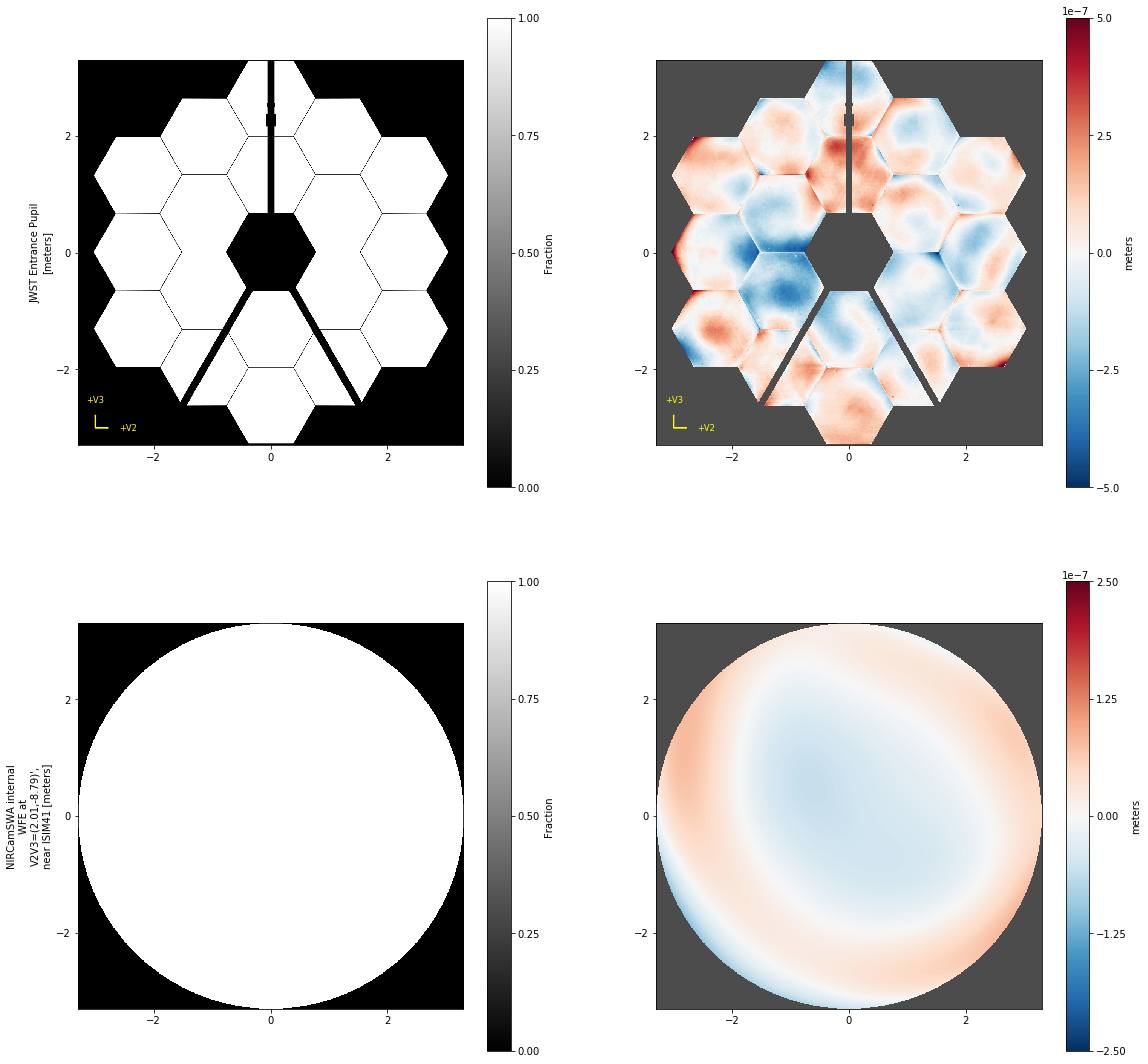

In [24]:
# Some displays
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

#nc.calc_psf?
#nc.calcPSF?

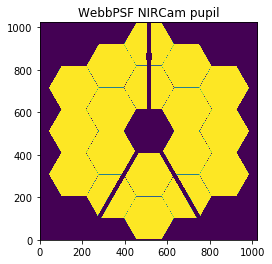

Pupil shape: (1024, 1024)


In [25]:
# Show the pupil used
nc_pup = fits.getdata(nc.pupil)
plt.imshow(nc_pup)
plt.title('WebbPSF NIRCam pupil')
plt.show()

print('Pupil shape:', nc_pup.shape)

In [26]:
# Null the OTE OPDs for the PSFs, and also the science instrument (SI) internal WFE.
nc, ote = webbpsf.enable_adjustable_ote(nc)                     # create OTE for default PSF
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote.zero()                       # set OTE for direct PSF to zero
ote_coro.zero()                  # set OTE for coronagraph to zero
nc.include_si_wfe= False         # set SI internal WFE to zero
nc_coro.include_si_wfe= False

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


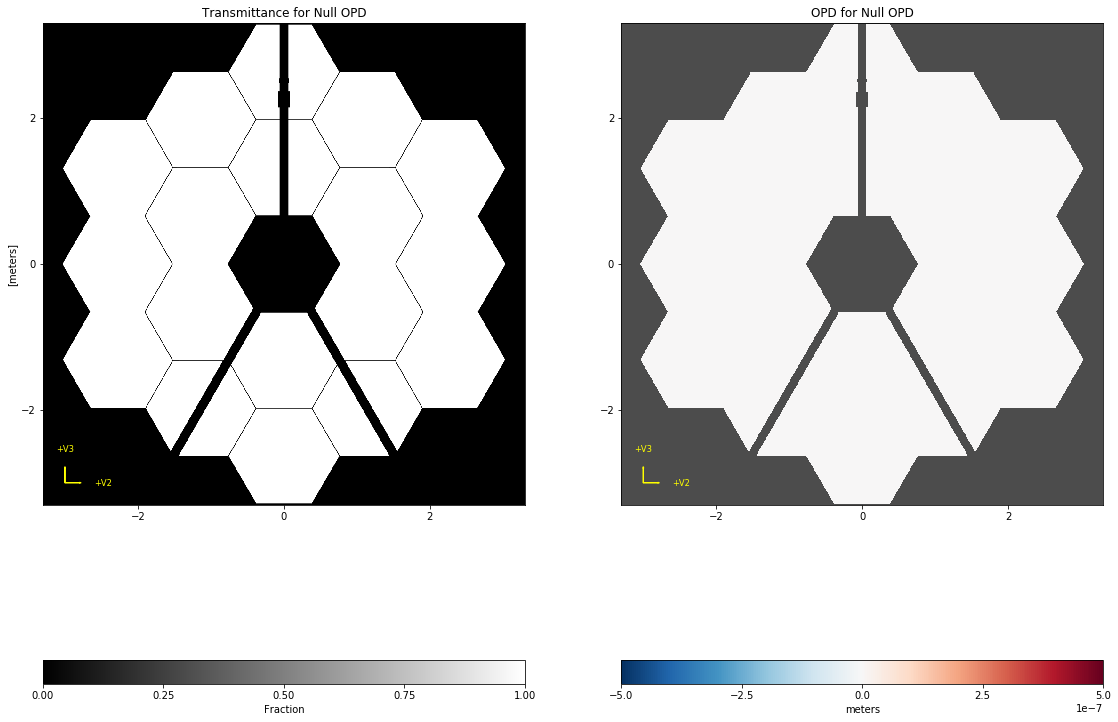

In [27]:
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

From the WebbPSF turotial (https://github.com/mperrin/webbpsf/blob/master/notebooks/WebbPSF_tutorial.ipynb) we know that calc_psf() calculates images with different sampling (I think I also explain this in my notebook "DealingWithWebbPSF.ipynb") and we can access them in the different HDU extensions.

In that same notebook, I also explain why I use oversample=1 and nlambda=1 to make the calculations faster.

## NO CORONAGRAPH

### Generating a direct PSF without aberrations

In [28]:
# Let's see what the current direct PSF looks like (coronagraphic PSF is the same since they've been set up the same
# and I haven't added the coronagraph yet)
psf_direct_hdu = nc.calc_psf(oversample=1, nlambda=1)

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


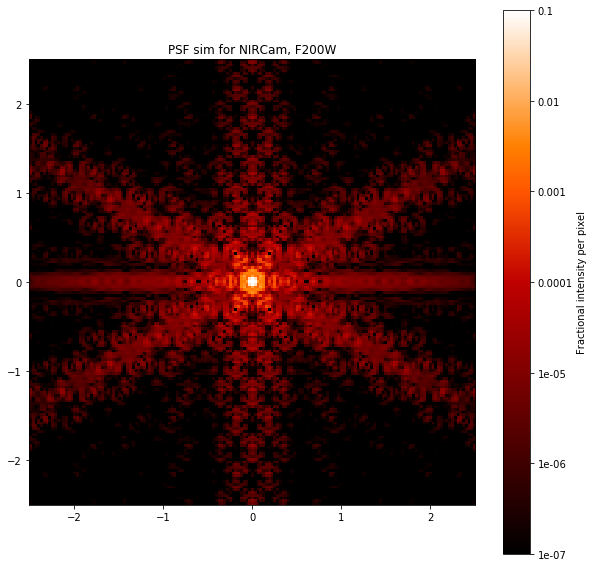

In [29]:
# Display by WebbPSF
plt.figure(figsize=(10,10))
webbpsf.display_psf(psf_direct_hdu)
plt.show()

PSF shape: (161, 161)


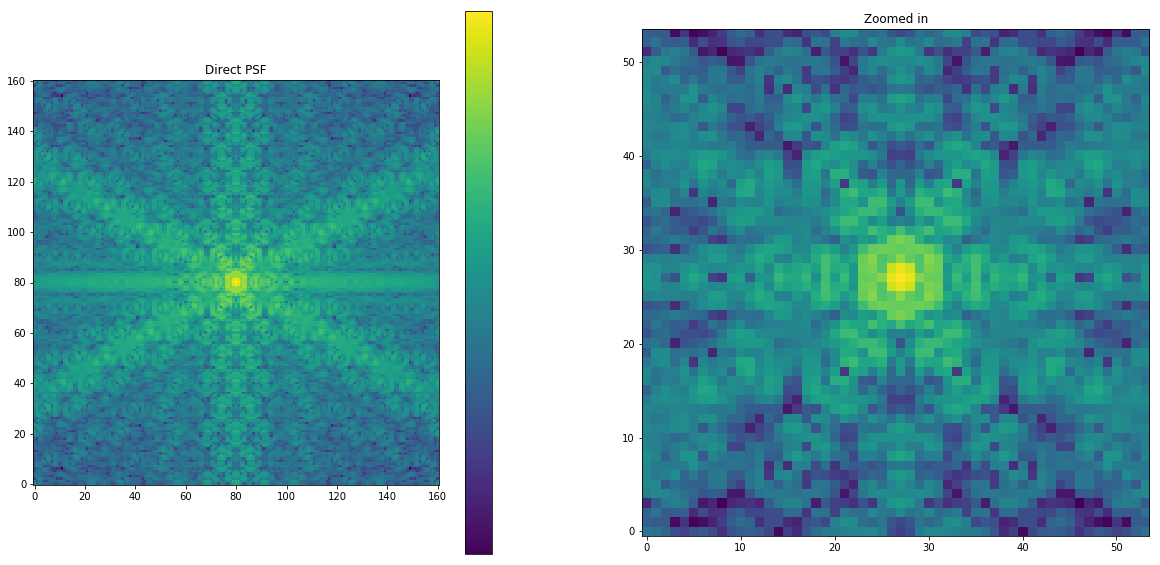

In [30]:
# Display with matplotlib
psf_direct = psf_direct_hdu[1].data
print('PSF shape:', psf_direct.shape)

xcen = int(psf_direct.shape[1]/2)
ycen = int(psf_direct.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(psf_direct, norm=LogNorm(), origin='lower')   # WebbPSF uses origin='lower' too, which will
plt.title('Direct PSF')                                  # be important later on with the coronagraphic images
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_direct[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Zoomed in')
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


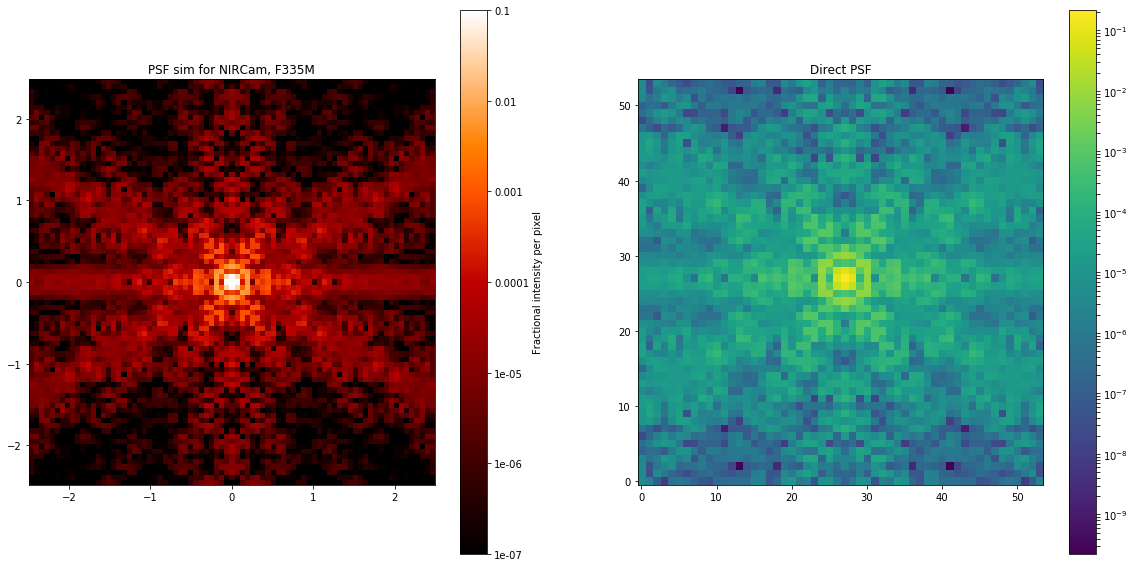

In [31]:
# Add the filter we want to use
nc.filter = filter
nc_coro.filter = filter

# So far both nc objects are still the same, so I'll display only one
psf = nc.calc_psf(oversample=1, nlambda=1)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
webbpsf.display_psf(psf)

psf = psf[1].data
xcen = int(psf.shape[1]/2)
ycen = int(psf.shape[0]/2)
boxhw = 27

plt.subplot(1, 2, 2)
plt.imshow(psf[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Direct PSF')
plt.colorbar()
plt.show()

We want our images to be the same size like our simulations, so we use "fov_pixels".

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


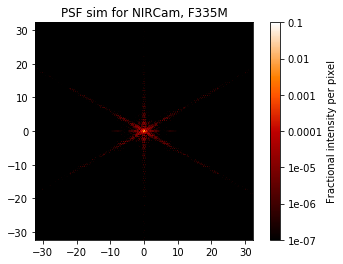

In [117]:
# Both nc (non-coro and coro) objects are still the same, so I'll display only one
psf = nc.calc_psf(fov_pixels=im_size_e2e, oversample=1, nlambda=1)
webbpsf.display_psf(psf)
plt.show()

Remember what the differend hdu extensions in the WebbPSF images are:
- If oversample = 1: image calculation with detector sampling, and extension 0 andn 1 are the same
- if oversample > 1: image calculation will be done with increased sampling and then binned down to detector sampling. This will make the calculation more accurate, since JWST observations will do things like dithering in order to make images better. Has to be done because some detectors in some wavelengths don't even have Nyquist sampling. Then ext=1 is oversampled image and ext=0 is binned image.

In [116]:
# Look at the different extensions of the WebbPSF image
psf.info()
webbpsf.display_psf(psf_minizern, ext=3)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

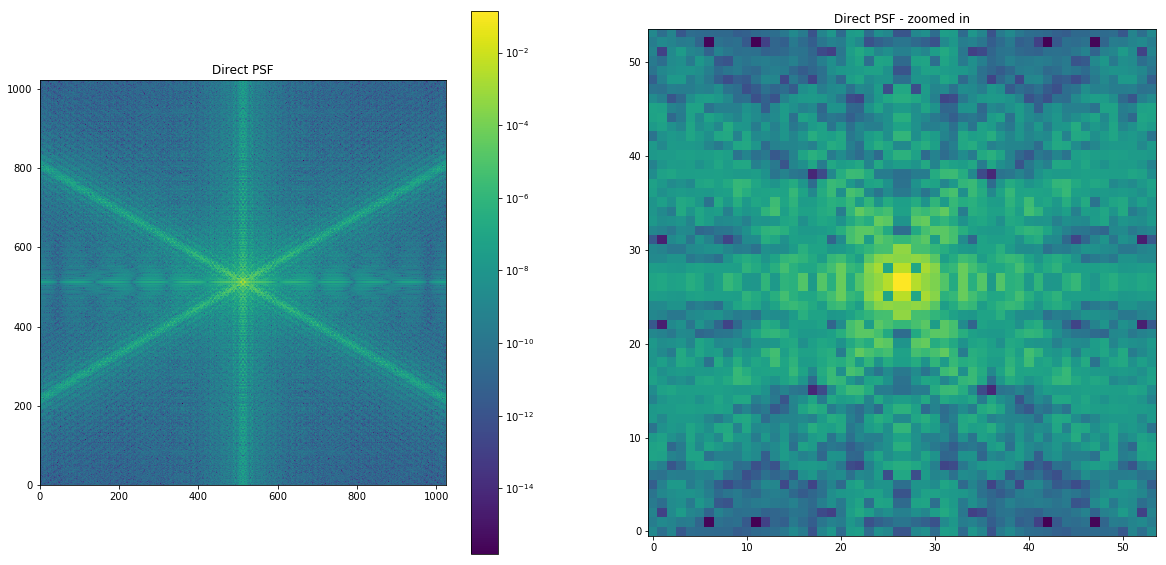

In [33]:
# Display with matplotlibpsf = psf[1].data

xcen = int(psf.shape[1]/2)
ycen = int(psf.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf, norm=LogNorm(), origin='lower')
plt.title('Direct PSF')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Direct PSF - zoomed in')
plt.show()

### A single aberrated segment

To compare to the analytical images step by step, I will first create images with only one segment aberrated.

In [110]:
segnum = 5     # Which segment are we aberrating - I number them starting with 1
segnum -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
nm_aber = 1000 # [nm]
# Extract the correct segment name from WebbPSF
seg = wss_segs[segnum].split('-')[0]
print('Aberrated segment:', seg)

Aberrated segment: A5


In [111]:
# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[segnum, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currently working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.

#-# Crate OPD with aberrated segment, NO CORONAGRAPH
print('Applying aberration to OTE.')
ote.reset()   # Making sure there are no previous movements on the segments.
ote.zero()    # For now, ignore internal WFE.
ote._apply_hexikes_to_seg(seg, Aber_WSS[segnum,:])

Applying aberration to OTE.


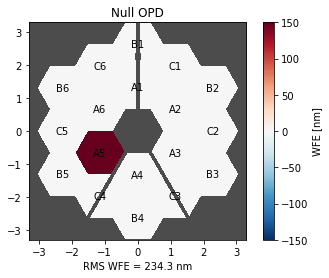

In [112]:
# Display the OTE
ote.display_opd()
plt.show()
# At this point, WebbPSF still numbers the segments wrong in the exit pupil,
# so it's the easiest to orient yourself by the spiders.

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


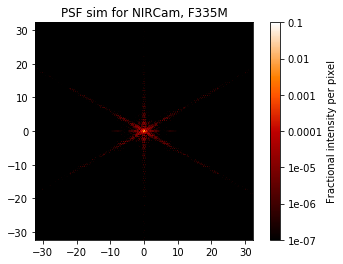

In [113]:
# Calculate the PSF
psf_minizern = nc.calc_psf(fov_pixels=im_size_e2e, oversample=1, nlambda=1)
webbpsf.display_psf(psf_minizern)
plt.show()

psf_minizern = psf_minizern[1].data

psf_minizern.shape: (1024, 1024)


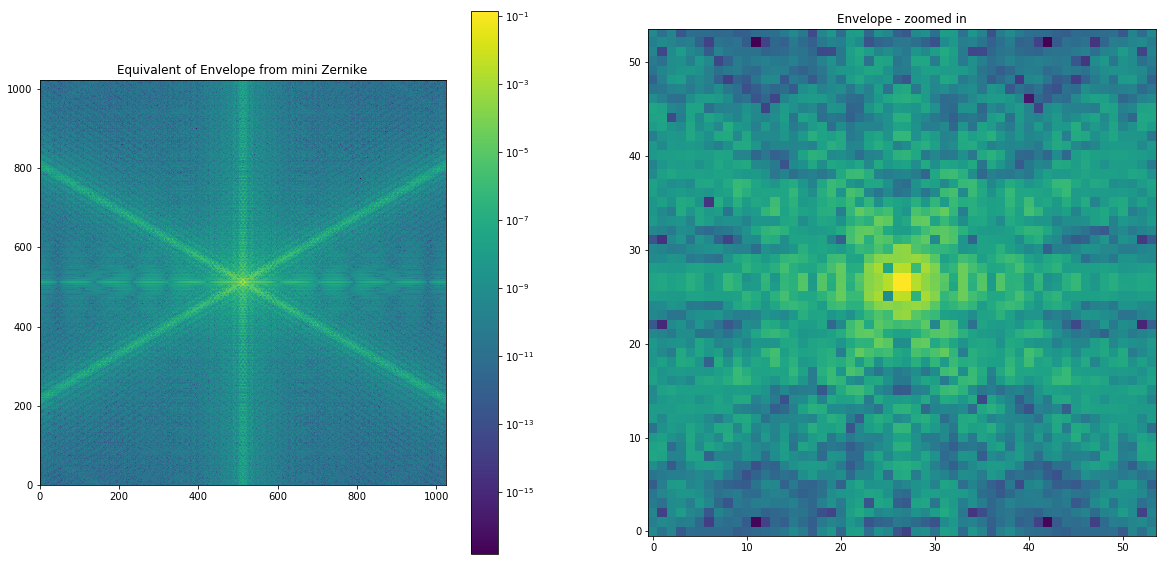

In [102]:
# Display with matplotlib
xcen = int(psf_minizern.shape[1]/2)
ycen = int(psf_minizern.shape[0]/2)
boxhw = 27

print('psf_minizern.shape:', psf_minizern.shape)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_minizern, norm=LogNorm(), origin='lower')
plt.title('Equivalent of Envelope from mini Zernike')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_minizern[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Envelope - zoomed in')
plt.show()

Compare this image with one single aberrated segment vs. the non-aberrated PSF:

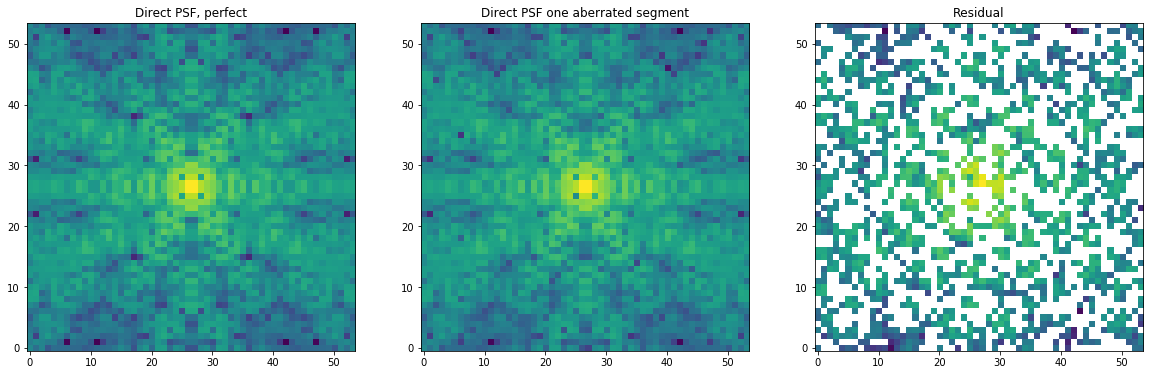

In [109]:
# Subtract the pserfect direct PSF off the single-segment aberrated PSF
one_aber_residual = psf - psf_minizern

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(psf[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Direct PSF, perfect')
#plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(psf_minizern[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Direct PSF one aberrated segment')
#plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(one_aber_residual[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Residual')
#plt.colorbar()
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


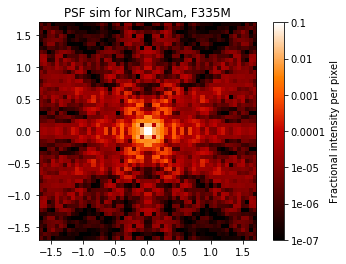

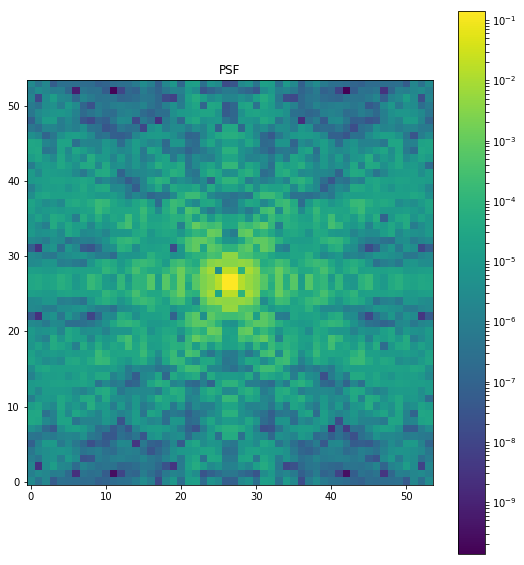

In [40]:
# Repeat on a smaller image direclty instead of cropping it afterwards, for faster computation
# Calculate the PSF
psf_minizern = nc.calc_psf(fov_pixels=54, oversample=1, nlambda=1)
webbpsf.display_psf(psf_minizern)
plt.show()

psf_minizern = psf_minizern[1].data

# Display with matplotlib
xcen = int(psf_minizern.shape[1]/2)
ycen = int(psf_minizern.shape[0]/2)
boxhw = 27

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_minizern, norm=LogNorm(), origin='lower')
plt.title('PSF')
plt.colorbar()
plt.show()

In [41]:
"""
# Make a loop over the first eight Zernike envelopes, like in notebook 2
aber_wss_loop = np.zeros([nb_seg, 8])
psfs_env = []
plt.figure(figsize=(18, 60))
plt.suptitle('Different Zernikes envelopes from WebbPSF')
noll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use
print('nm_aber:', nm_aber, 'nm')

for i, zern in enumerate(noll_as_wss):
    
    # Put the Zernike coefficient in correct place in
    aber_wss_loop[:,:] = 0     # set all entries to zero
    aber_wss_loop[segnum, zern-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters
    #print(aber_wss_loop[segnum, :])
    
    # Put Zernike on correct segment on OTE
    ote.reset()   # Making sure there are no previous movements on the segments.
    ote.zero()    # For now, ignore internal WFE.
    ote._apply_hexikes_to_seg(seg, aber_wss_loop[segnum,:])
    
    # Display the OTE
    plt.subplot(8, 2, i*2+1)
    ote.display_opd()
    
    # Calculate the PSF
    print('Calculating PSF', str(i+1) + '/' + '8')
    psf_zernloop = nc.calc_psf(fov_pixels=54, oversample=1, nlambda=1)
    psf_zernloop = psf_zernloop[1].data
    psfs_env.append(psf_zernloop)
    
    # Display the PSF
    plt.subplot(8, 2, i*2+2)
    plt.imshow(psf_zernloop, norm=LogNorm(), origin='lower')
    
plt.show()
psfs_env = np.array(psfs_env)
"""

# This was a thought mistake from my side. I tried modeling the single Zernike envelope
# from the analytical model, which I can't do direcly in this simulation because I only
# have access to the full aperture.

# But I'll keep the code, because you neve rknow what it could be useful for.

"\n# Make a loop over the first eight Zernike envelopes, like in notebook 2\naber_wss_loop = np.zeros([nb_seg, 8])\npsfs_env = []\nplt.figure(figsize=(18, 60))\nplt.suptitle('Different Zernikes envelopes from WebbPSF')\nnoll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use\nprint('nm_aber:', nm_aber, 'nm')\n\nfor i, zern in enumerate(noll_as_wss):\n    \n    # Put the Zernike coefficient in correct place in\n    aber_wss_loop[:,:] = 0     # set all entries to zero\n    aber_wss_loop[segnum, zern-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters\n    #print(aber_wss_loop[segnum, :])\n    \n    # Put Zernike on correct segment on OTE\n    ote.reset()   # Making sure there are no previous movements on the segments.\n    ote.zero()    # For now, ignore internal WFE.\n    ote._apply_hexikes_to_seg(seg, aber_wss_loop[segnum,:])\n    \n    # Display the OTE\n    plt.subplot(8, 2, i*2+1)\n    ote.display_op

In [42]:
"""
# Display them
plt.figure(figsize=(16, 8))
for i in range(noll_as_wss.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(psfs_env[i], norm=LogNorm(), origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()
"""

"\n# Display them\nplt.figure(figsize=(16, 8))\nfor i in range(noll_as_wss.shape[0]):\n    plt.subplot(2, 4, i+1)\n    plt.imshow(psfs_env[i], norm=LogNorm(), origin='lower')\n    plt.title('Noll Zernike: ' + str(i+1))\nplt.show()\n"

### Pair-wise aberrated segments

In [84]:
# Decide which two segments you want to aberrate
segnum1 = 8     # Which segments are we aberrating - I number them starting with 1
segnum2 = 16

segnum_array = np.array([segnum1, segnum2])
segnum_array -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
#nm_aber = 1000.

zern_pair = 1  # Which Noll Zernike are we putting on the segments.

# Extract the correct segment names from WebbPSF
seg_array = []
for i, senu in enumerate(segnum_array):
    seg_array.append(wss_segs[senu].split('-')[0])

seg_array = np.array(seg_array)
print('Aberrated segments:', seg_array)
print('Noll Zernike used:', zern_pair)

Aberrated segments: ['C1' 'C5']
Noll Zernike used: 1


nm_aber: 100.0 nm


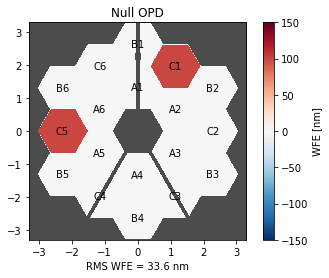

In [85]:
aber_wss_loop = np.zeros([nb_seg, 8])
noll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use
print('nm_aber:', nm_aber, 'nm')

# Apply aberration to all sgements
ote.reset()   # Making sure there are no previous movements on the segments.
ote.zero()    # For now, ignore internal WFE.
for i, nseg in enumerate(seg_array):
    aber_wss_loop[segnum_array[i], noll_as_wss[zern_pair-1]-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters

    # Put Zernike on correct segments on OTE
    ote._apply_hexikes_to_seg(nseg, aber_wss_loop[segnum_array[i],:])

# Display the OTE
ote.display_opd()
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


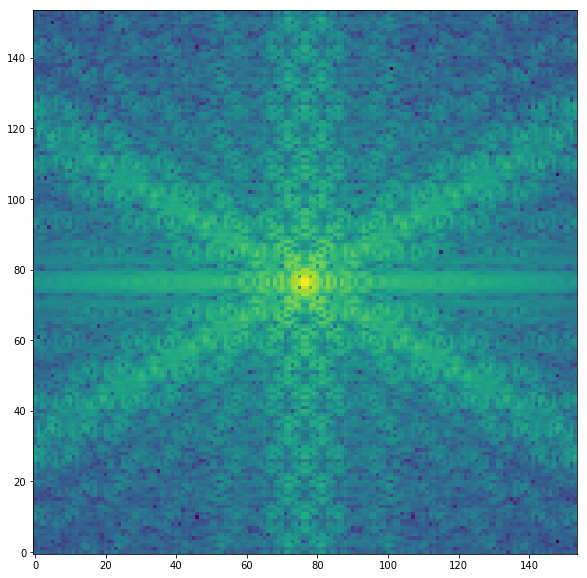

(154, 154)


In [86]:
# Calculate the PSF
psf_zernpair= nc.calc_psf(fov_pixels=154, oversample=1, nlambda=1)   # oversampled for beeter seeign the fringes
psf_zernpair = psf_zernpair[0].data                                  # getting the oversampled extension
    
# Display the PSF
plt.figure(figsize=(10, 10))
plt.imshow(psf_zernpair, norm=LogNorm(), origin='lower')
plt.show()

print(psf_zernpair.shape)

I'm gonna stop here and go back to do the same thing with the analytical model in notebook 2. I am not sure the effect in the focal plane of me aberrating a pair of segments is really what it's supposed to be.

I created some images from specific paris and then saved them:

In [87]:
#segs_3_11_noll_1_dir = np.copy(psf_zernpair)
#segs_11_17_noll_1_dir = np.copy(psf_zernpair)
#segs_6_11_noll_1_dir = np.copy(psf_zernpair)
#segs_9_2_noll_1_dir = np.copy(psf_zernpair)
#segs_9_5_noll_1_dir = np.copy(psf_zernpair)
#segs_9_15_noll_1_dir = np.copy(psf_zernpair)
#segs_8_1_noll_1_dir = np.copy(psf_zernpair)
#segs_8_6_noll_1_dir = np.copy(psf_zernpair)
#segs_8_16_noll_1_dir = np.copy(psf_zernpair)

In [88]:
save_dir1 = '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-25-16h-18min_piston_100nm'
# util.write_fits(segs_3_11_noll_1_dir, os.path.join(save_dir1, 'segs_3_11_noll_1_dir.fits'))
# util.write_fits(segs_11_17_noll_1_dir, os.path.join(save_dir1, 'segs_11_17_noll_1_dir.fits'))
# util.write_fits(segs_6_11_noll_1_dir, os.path.join(save_dir1, 'segs_6_11_noll_1_dir.fits'))
# util.write_fits(segs_9_2_noll_1_dir, os.path.join(save_dir1, 'segs_9_2_noll_1_dir.fits'))
# util.write_fits(segs_9_5_noll_1_dir, os.path.join(save_dir1, 'segs_9_5_noll_1_dir.fits'))
# util.write_fits(segs_9_15_noll_1_dir, os.path.join(save_dir1, 'segs_9_15_noll_1_dir.fits'))
# util.write_fits(segs_8_1_noll_1_dir, os.path.join(save_dir1, 'segs_8_1_noll_1_dir.fits'))
# util.write_fits(segs_8_6_noll_1_dir, os.path.join(save_dir1, 'segs_8_6_noll_1_dir.fits'))
# util.write_fits(segs_8_16_noll_1_dir, os.path.join(save_dir1, 'segs_8_16_noll_1_dir.fits'))

'/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-25-16h-18min_piston_100nm/segs_8_16_noll_1_dir.fits'

In general, I will have to load these images from central store:
- '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-18-17h-5min_piston_1000nm_pairs' will have images generated with aberrations of 1000 nm per segment which is too much compared to JWST's wavelength and the sort of aberrations that are expected in-flight
- '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-25-16h-18min_piston_100nm' has images generated with aberrations of 100 nm per segment, but this aberration is not high enough to make us see the fringes


In [96]:
read_dir1 = '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-18-17h-5min_piston_1000nm_pairs'
segs_3_11_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_3_11_noll_1_dir.fits'))
segs_11_17_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_11_17_noll_1_dir.fits'))
segs_6_11_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_6_11_noll_1_dir.fits'))
segs_9_2_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_9_2_noll_1_dir.fits'))
segs_9_5_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_9_5_noll_1_dir.fits'))
segs_9_15_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_9_15_noll_1_dir.fits'))
segs_8_1_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_8_1_noll_1_dir.fits'))
segs_8_6_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_8_6_noll_1_dir.fits'))
segs_8_16_noll_1_dir = fits.getdata(os.path.join(read_dir1, 'segs_8_16_noll_1_dir.fits'))

Let's have a look at some of the images (refer to numbered pupil to identify baslines these correspond to).

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: using a no

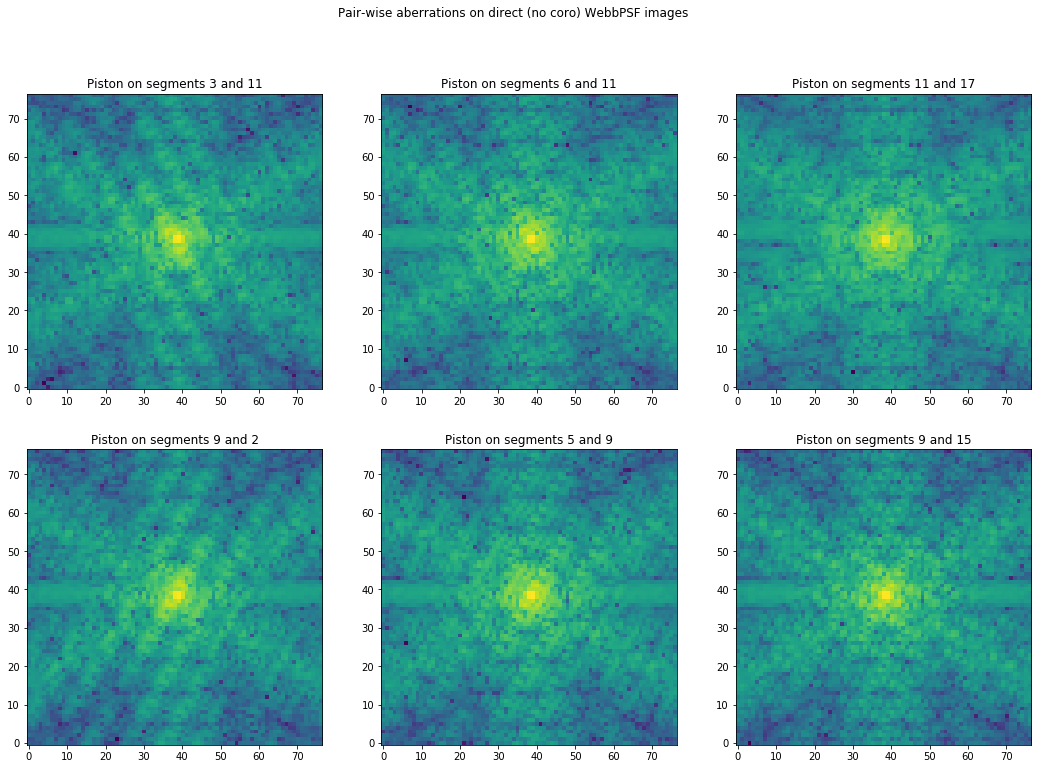

In [97]:
xcen = int(psf_zernpair.shape[1]/2.)
ycen = int(psf_zernpair.shape[0]/2.)
boxw = int(154/2)    # We can see in the 3. notebook that WebbPSF produces 161 x 161 px images by default.
boxw2 = boxw/2

# Chose what image size (in pixels) we want to display
imwidth = boxw2

plt.figure(figsize=(18, 12))
plt.suptitle('Pair-wise aberrations on direct (no coro) WebbPSF images')
plt.subplot(2, 3, 1)
plt.imshow(segs_3_11_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 3 and 11')

plt.subplot(2, 3, 2)
plt.imshow(segs_6_11_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 6 and 11')

plt.subplot(2, 3, 3)
plt.imshow(segs_11_17_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 11 and 17')

plt.subplot(2, 3, 4)
plt.imshow(segs_9_2_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 2')

plt.subplot(2, 3, 5)
plt.imshow(segs_9_5_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 5 and 9')

plt.subplot(2, 3, 6)
plt.imshow(segs_9_15_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 15')

plt.show()

I made sure to make images from the same aberrated pairs like in the analytical notebook (notebook 2), so we can compare them here now.

In [31]:
# Load the analytical images
read_dir_ana = '/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-19-18h-31min_piston_exitpupil'
segs_3_11_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_3_11_noll_1.fits'))
segs_11_17_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_11_17_noll_1.fits'))
segs_6_11_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_6_11_noll_1.fits'))
segs_9_2_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_9_2_noll_1.fits'))
segs_9_5_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_9_5_noll_1.fits'))
segs_9_15_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_9_15_noll_1.fits'))
segs_8_1_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_8_1_noll_1.fits'))
segs_8_6_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_8_6_noll_1.fits'))
segs_8_16_noll_1_ana = fits.getdata(os.path.join(read_dir_ana, 'segs_8_16_noll_1.fits'))

Compare pairs **3-11**, **6-11** and **11-17** between E2E and analytical:

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using

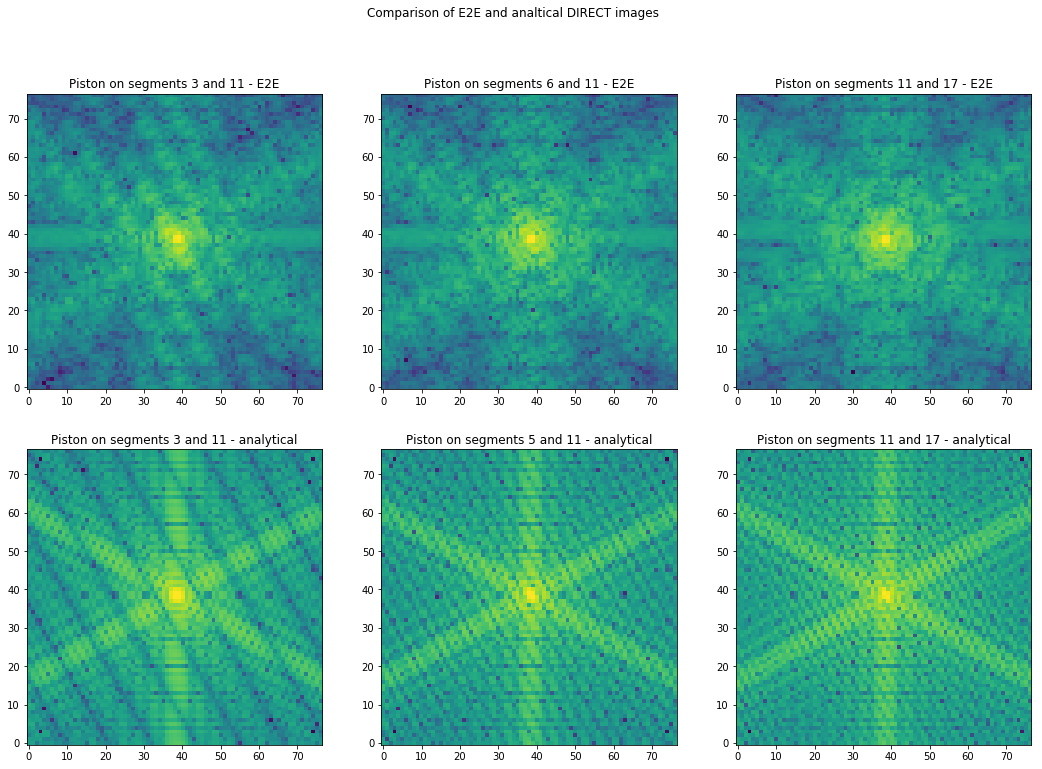

In [32]:
xcen_ana = int(segs_3_11_noll_1_ana.shape[1]/2.)
ycen_ana = int(segs_3_11_noll_1_ana.shape[0]/2.)

# Chose what image size (in pixels) we want to display
imwidth = boxw2

plt.figure(figsize=(18, 12))
plt.suptitle('Comparison of E2E and analtical DIRECT images')
plt.subplot(2, 3, 1)
plt.imshow(segs_3_11_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 3 and 11 - E2E')

plt.subplot(2, 3, 2)
plt.imshow(segs_6_11_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 6 and 11 - E2E')

plt.subplot(2, 3, 3)
plt.imshow(segs_11_17_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 11 and 17 - E2E')

plt.subplot(2, 3, 4)
plt.imshow(segs_3_11_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 3 and 11 - analytical')

plt.subplot(2, 3, 5)
plt.imshow(segs_6_11_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 5 and 11 - analytical')

plt.subplot(2, 3, 6)
plt.imshow(segs_11_17_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 11 and 17 - analytical')

plt.show()

There is clearly a lot more going on in the WebbPSF images, since they will have incorporated many additional effects compared to the analytical images. But, foro the same aberrated segment, we can see fringes of the same structure and orientation, so I think this is fine!

## WITH CORONAGRAPH

### Generating a coronagraphic PSF without aberrations

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


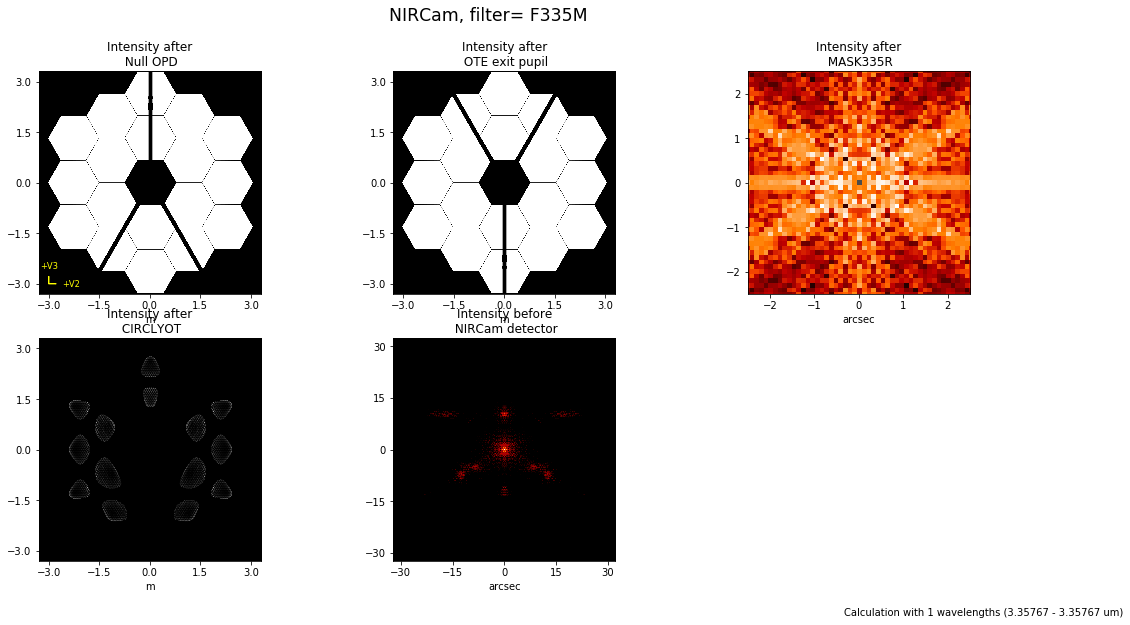

PSF calculation done


In [33]:
# Now add the coronagraph to nc_coro
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# And show what that looks like
plt.figure(figsize=(18, 9))
psf_coro = nc_coro.calc_psf(fov_pixels=im_size_e2e, oversample=1, nlambda=1, display=True)
plt.show()
psf_coro_im = psf_coro[1].data

print('PSF calculation done')

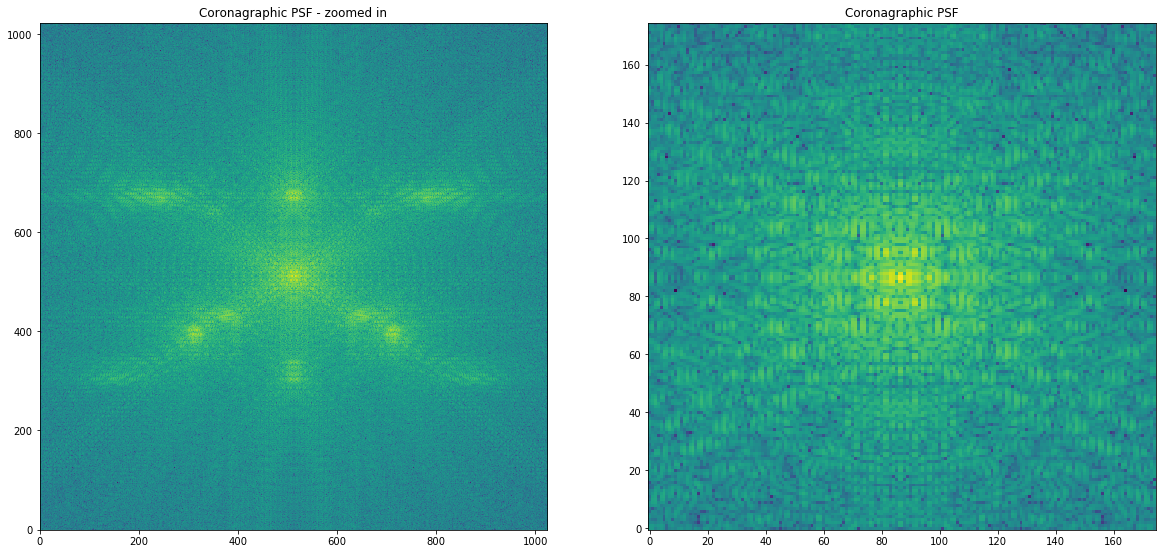

In [34]:
# I can't use webbpsf.display_psf(psf_coro) because I couldn't figure out how to change the color scaling
# and it turns out all black. So I'll just use matplotlib.
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_coro_im, norm=LogNorm(), origin='lower')
plt.title('Coronagraphic PSF - zoomed in')
#plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_coro_im[425:600, 425:600], norm=LogNorm(), origin='lower')
plt.title('Coronagraphic PSF')
plt.show()

In [49]:
20/0.063

317.46031746031747

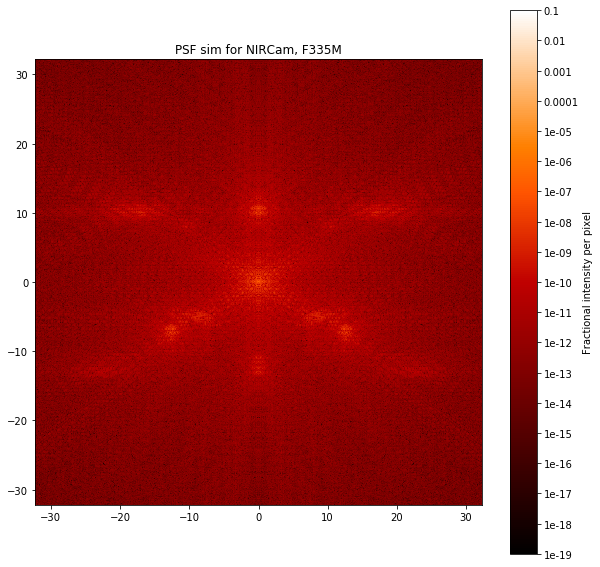

In [35]:
# For comparison, the webbpsf display in physical units for the fov:
plt.figure(figsize=(10, 10))
webbpsf.display_psf(psf_coro, vmin=1e-19)
plt.show()

You can see that the coronagraphic PSF is not centro-symmetric, but it does have one symmetry axis. This is because of the weird symmetry of the lyot stop, which you can see above. This is also the place where we can see that in order to match our matplotlib displays of the PSF with that of WebbPSF, we need to use the keyword "origin='lower'" in imshow().

### A single aberrated segment

For the calibration of the analytical images, I need to create images that stem for the pupil having one single aberrated segment.

Aberrated segment: A5
Applying aberration to OTE.
nm_aber: 100.0 nm


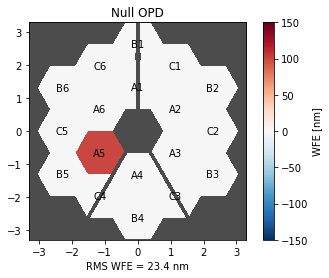

In [61]:
# Define what segment to aberrate
segnum = 5     # Which segment are we aberrating - I number them starting with 1
segnum -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
# Extract the correct segment name from WebbPSF
seg = wss_segs[segnum].split('-')[0]
print('Aberrated segment:', seg)

# Define what Noll Zernike we're using
zern_number = 1
wss_zern_nb = util.noll_to_wss(zern_number)  

# Maybe play around with amount of aberration
#nm_aber = 1000.     # in nm

# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[segnum, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currently working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.

#-# Crate OPD with aberrated segment, NO CORONAGRAPH
print('Applying aberration to OTE.')
print('nm_aber:', nm_aber, 'nm')
ote_coro.reset()   # Making sure there are no previous movements on the segments.
ote_coro.zero()    # For now, ignore internal WFE.
ote_coro._apply_hexikes_to_seg(seg, Aber_WSS[segnum,:])

# Display the OTE
ote_coro.display_opd()
plt.show()
# At this point, WebbPSF still numbers the segments wrong in the exit pupil,
# so it's the easiest to orient yourself by the spiders.

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


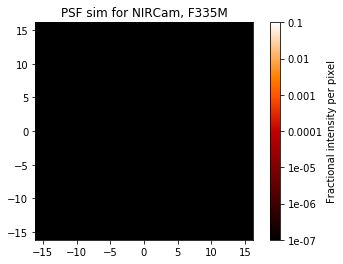

In [62]:
# Calculate the PSF
psf_single_coro = nc_coro.calc_psf(fov_pixels=im_size_e2e, oversample=1, nlambda=1)
webbpsf.display_psf(psf_single_coro)
plt.show()

psf_single_coro = psf_single_coro[1].data

nm_aber: 100.0 nm


/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


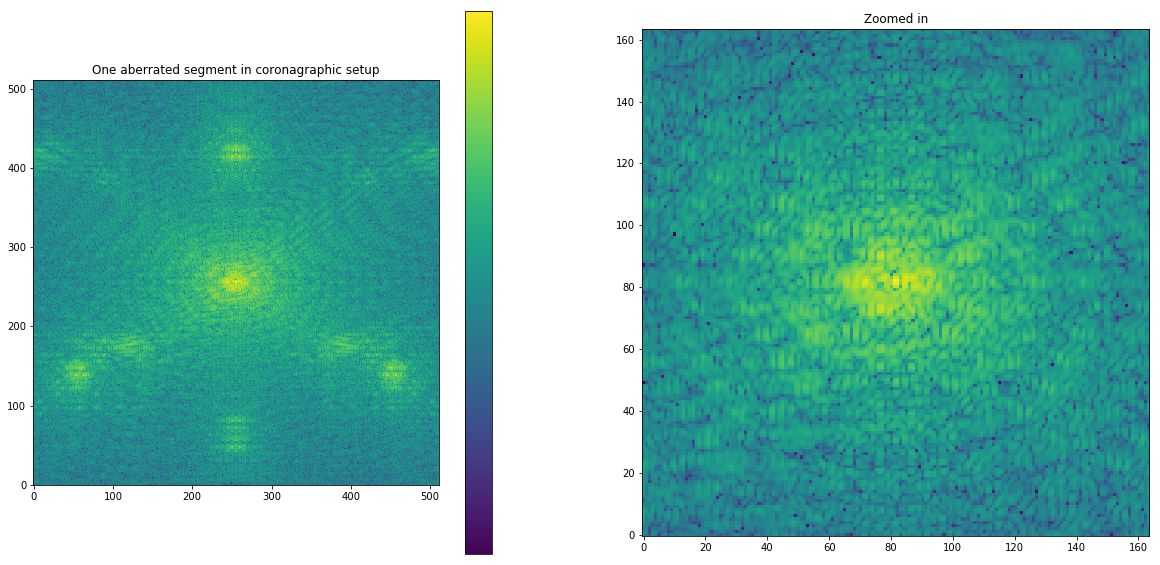

In [63]:
# Display with matplotlib
xcen = int(psf_single_coro.shape[1]/2)
ycen = int(psf_single_coro.shape[0]/2)
boxhw = 164/2

print('nm_aber:', nm_aber, 'nm')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf_single_coro, norm=LogNorm(), origin='lower')
plt.title('One aberrated segment in coronagraphic setup')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_single_coro[ycen-boxhw:ycen+boxhw, xcen-boxhw:xcen+boxhw], norm=LogNorm(), origin='lower')
plt.title('Zoomed in')
plt.show()

For piston, an aberration of 10 nm shows no effect, 100 nm already visibly messes the PSF up and 1000 nm make a very distinct change to the PSF.

### Pair-wise aberrated segments with coronagraph

In [67]:
# Decide which two segments you want to aberrate
segnum1 = 8     # Which segments are we aberrating - I number them starting with 1
segnum2 = 16

segnum_array = np.array([segnum1, segnum2])
segnum_array -= 1    # Which is why I have to subtract one, because WebbPSF starts numbering them at 0
#nm_aber = 100.

zern_pair = 1  # Which Noll Zernike are we putting on the segments.

# Extract the correct segment names from WebbPSF
seg_array = []
for i, senu in enumerate(segnum_array):
    seg_array.append(wss_segs[senu].split('-')[0])

seg_array = np.array(seg_array)
print('Aberrated segments:', seg_array)
print('Noll Zernike used:', zern_pair)

Aberrated segments: ['C1' 'C5']
Noll Zernike used: 1


nm_aber: 100.0 nm


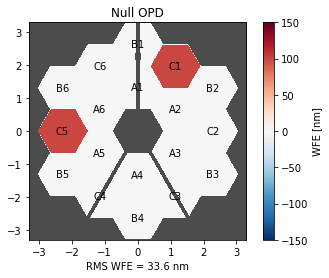

In [68]:
aber_wss_loop = np.zeros([nb_seg, 8])
noll_as_wss = np.array([1, 3, 2, 5, 4, 6, 7, 8]) #, 11, 9, 10])    # reordering Noll Zernikes to WSS, for ease of use
print('nm_aber:', nm_aber, 'nm')

# Apply aberration to all sgements
ote_coro.reset()   # Making sure there are no previous movements on the segments.
ote_coro.zero()    # For now, ignore internal WFE.
for i, nseg in enumerate(seg_array):
    aber_wss_loop[segnum_array[i], noll_as_wss[zern_pair-1]-1] = nm_aber / 1e9   # fill only the index for current Zernike, in meters

    # Put Zernike on correct segments on OTE
    ote_coro._apply_hexikes_to_seg(nseg, aber_wss_loop[segnum_array[i],:])

# Display the OTE
ote_coro.display_opd()
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


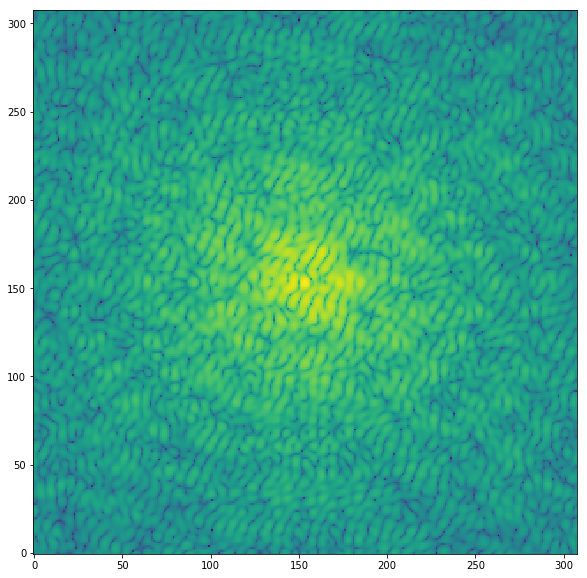

nm_aber: 100.0 nm
Aberrated segments: ['C1' 'C5']
Noll Zernike used: 1
(308, 308)


In [69]:
# Calculate the PSF
psf_coro_pair= nc_coro.calc_psf(fov_pixels=154, oversample=2, nlambda=1)
psf_coro_pair = psf_coro_pair[0].data                                  # getting the oversampled extension
    
# Display the PSF
plt.figure(figsize=(10, 10))
plt.imshow(psf_coro_pair, norm=LogNorm(), origin='lower')
plt.show()

print('nm_aber:', nm_aber, 'nm')
print('Aberrated segments:', seg_array)
print('Noll Zernike used:', zern_pair)
print(psf_coro_pair.shape)

In [42]:
#segs_3_11_noll_1_coro = np.copy(psf_coro_pair)
#segs_11_17_noll_1_coro = np.copy(psf_coro_pair)
#segs_6_11_noll_1_coro = np.copy(psf_coro_pair)
#segs_9_2_noll_1_coro = np.copy(psf_coro_pair)
#segs_9_5_noll_1_coro = np.copy(psf_coro_pair)
#segs_9_15_noll_1_coro = np.copy(psf_coro_pair)
#segs_8_1_noll_1_coro = np.copy(psf_coro_pair)
#segs_8_6_noll_1_coro = np.copy(psf_coro_pair)
#segs_8_16_noll_1_coro = np.copy(psf_coro_pair)

In [43]:
# Save to central store
save_dir1 = '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-22-9h-53min'
#util.write_fits(segs_3_11_noll_1_coro, os.path.join(save_dir1, 'segs_3_11_noll_1_coro.fits'))
#util.write_fits(segs_11_17_noll_1_coro, os.path.join(save_dir1, 'segs_11_17_noll_1_coro.fits'))
#util.write_fits(segs_6_11_noll_1_coro, os.path.join(save_dir1, 'segs_6_11_noll_1_coro.fits'))
#util.write_fits(segs_9_2_noll_1_coro, os.path.join(save_dir1, 'segs_9_2_noll_1_coro.fits'))
#util.write_fits(segs_9_5_noll_1_coro, os.path.join(save_dir1, 'segs_9_5_noll_1_coro.fits'))
#util.write_fits(segs_9_15_noll_1_coro, os.path.join(save_dir1, 'segs_9_15_noll_1_coro.fits'))

#util.write_fits(segs_8_1_noll_1_coro, os.path.join(save_dir1, 'segs_8_1_noll_1_coro.fits'))
#util.write_fits(segs_8_6_noll_1_coro, os.path.join(save_dir1, 'segs_8_6_noll_1_coro.fits'))
#util.write_fits(segs_8_16_noll_1_coro, os.path.join(save_dir1, 'segs_8_16_noll_1_coro.fits'))

In [44]:
# Read from central store
read_dir1 = '/astro/opticslab1/PASTIS/jwst_data/E2E_pair_aberrations/2019-1-22-9h-53min_coro_piston_pairs'
segs_3_11_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_3_11_noll_1.fits'))
segs_11_17_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_11_17_noll_1.fits'))
segs_6_11_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_6_11_noll_1.fits'))
segs_9_2_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_9_2_noll_1.fits'))
segs_9_5_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_9_5_noll_1.fits'))
segs_9_15_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_9_15_noll_1.fits'))

segs_8_1_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_8_1_noll_1.fits'))
segs_8_6_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_8_6_noll_1.fits'))
segs_8_16_noll_1_coro = fits.getdata(os.path.join(read_dir1, 'segs_8_16_noll_1.fits'))

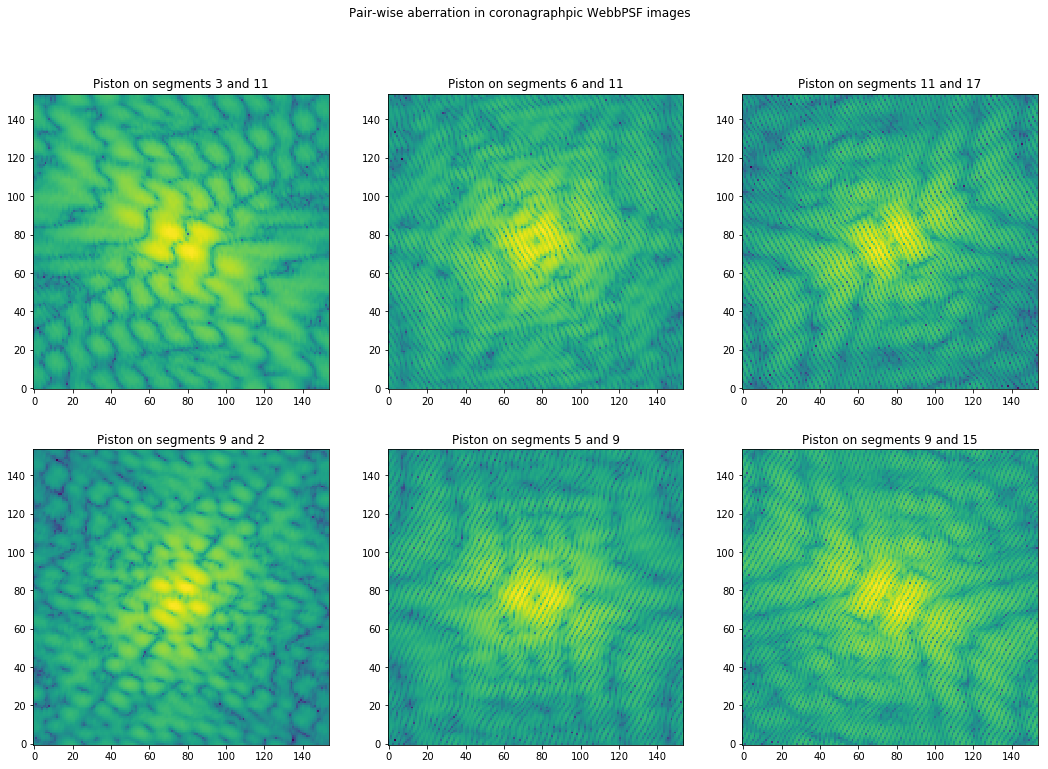

In [59]:
# Have a look at the images

xcen = int(segs_11_17_noll_1_coro.shape[1]/2.)
ycen = int(segs_11_17_noll_1_coro.shape[0]/2.)
boxw = int(154/2)    # We can see in the 3. notebook that WebbPSF produces 161 x 161 px images by default.
boxw2 = boxw/2

# Chose what image size (in pixels) we want to display
imwidth = boxw

plt.figure(figsize=(18, 12))
plt.suptitle('Pair-wise aberration in coronagraphpic WebbPSF images')
plt.subplot(2, 3, 1)
plt.imshow(segs_3_11_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 3 and 11')

plt.subplot(2, 3, 2)
plt.imshow(segs_6_11_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 6 and 11')

plt.subplot(2, 3, 3)
plt.imshow(segs_11_17_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 11 and 17')

plt.subplot(2, 3, 4)
plt.imshow(segs_9_2_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 2')

plt.subplot(2, 3, 5)
plt.imshow(segs_9_5_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 5 and 9')

plt.subplot(2, 3, 6)
plt.imshow(segs_9_15_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 15')

plt.show()

We're missing one intermediate baseline with these combinations though, because we have to skip the center segment. I want to know what that looks like though, so here's some more images.

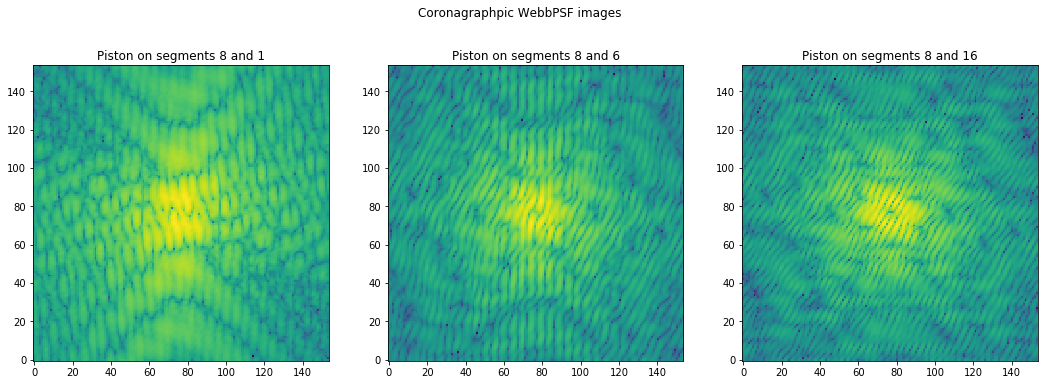

In [60]:
# Chose what image size (in pixels) we want to display
imwidth = boxw

plt.figure(figsize=(18, 6))
plt.suptitle('Coronagraphpic WebbPSF images')
plt.subplot(1, 3, 1)
plt.imshow(segs_8_1_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 1')

plt.subplot(1, 3, 2)
plt.imshow(segs_8_6_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 6')

plt.subplot(1, 3, 3)
plt.imshow(segs_8_16_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 16')

plt.show()

## COMPARING ANALYTICAL, E2E DIRECT AND E2E CORONAGRAPHIC

Display comparison for **piston** with the pairs **9-2**, **9-5** and **9-15**.

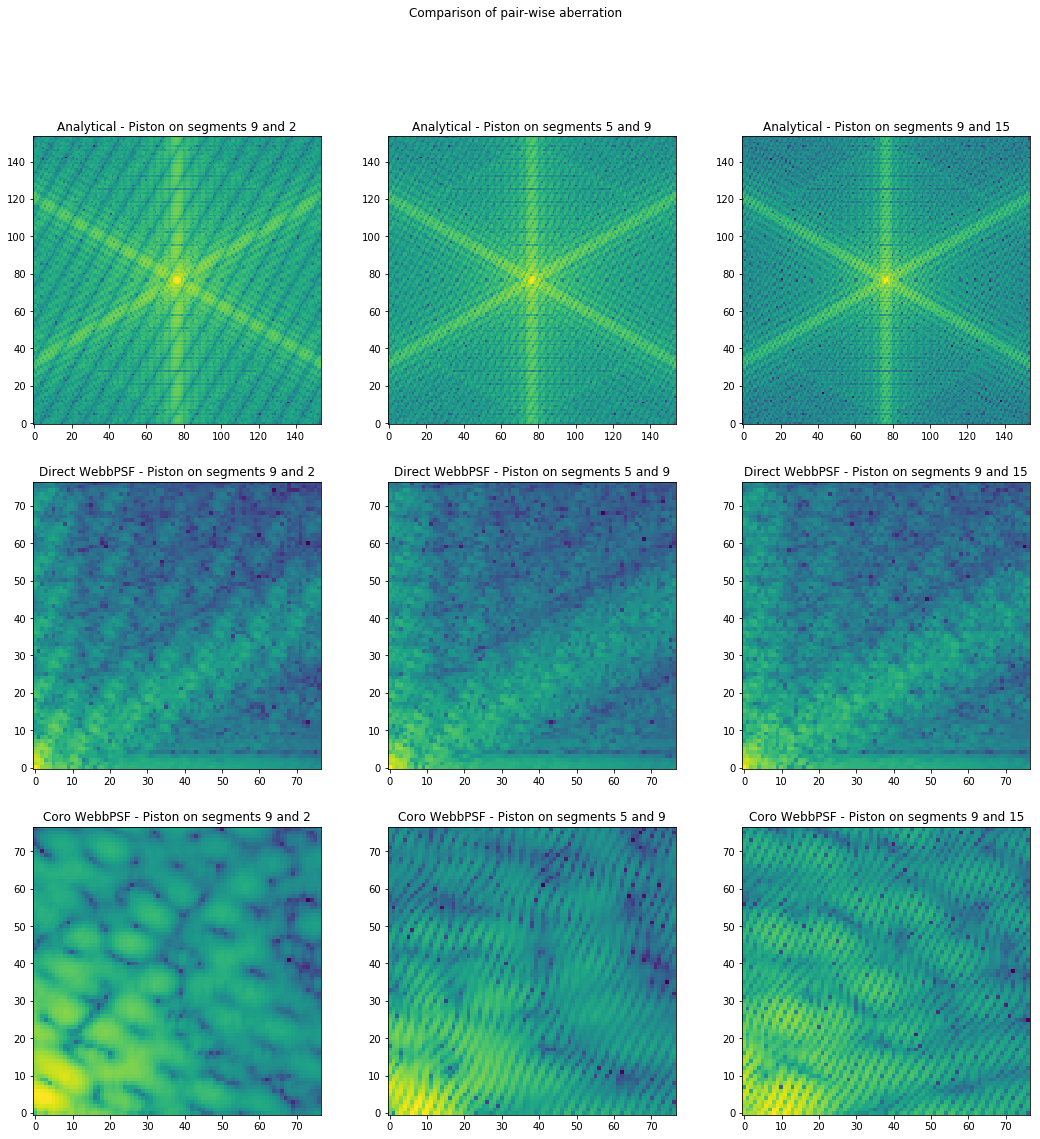

In [47]:
# Chose what image size (in pixels) we want to display
imwidth = boxw

plt.figure(figsize=(18, 18))
plt.suptitle('Comparison of pair-wise aberration')
plt.subplot(3, 3, 1)
plt.imshow(segs_9_2_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 9 and 2')

plt.subplot(3, 3, 2)
plt.imshow(segs_9_5_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 5 and 9')

plt.subplot(3, 3, 3)
plt.imshow(segs_9_15_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 9 and 15')

plt.subplot(3, 3, 4)
plt.imshow(segs_9_2_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 9 and 2')

plt.subplot(3, 3, 5)
plt.imshow(segs_9_5_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 5 and 9')

plt.subplot(3, 3, 6)
plt.imshow(segs_9_15_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 9 and 15')

plt.subplot(3, 3, 7)
plt.imshow(segs_9_2_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 9 and 2')

plt.subplot(3, 3, 8)
plt.imshow(segs_9_5_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 5 and 9')

plt.subplot(3, 3, 9)
plt.imshow(segs_9_15_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 9 and 15')

plt.show()

Display the comparison for **piston** with the pairs **8-1**, **8-6** and **8-16**.

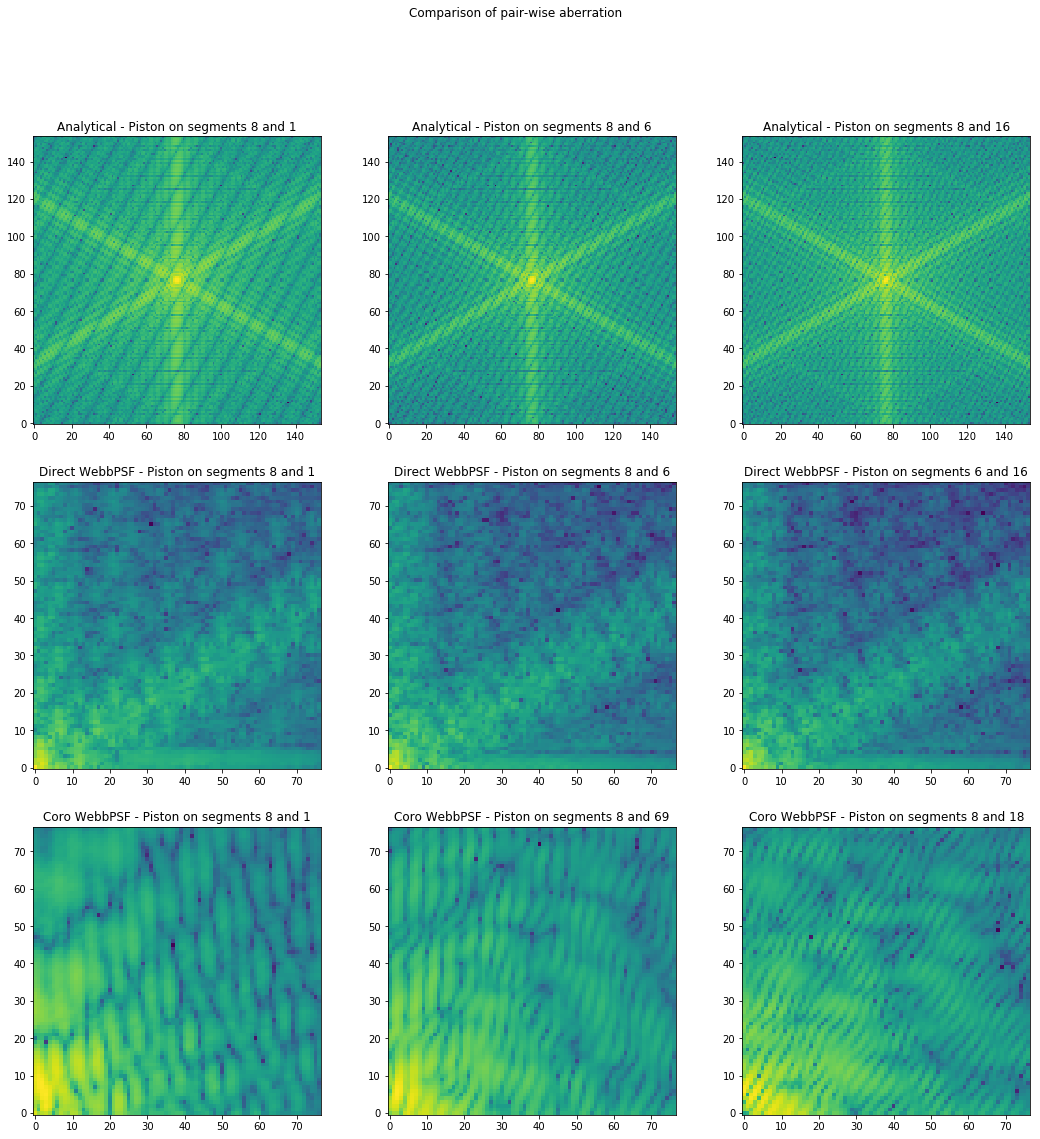

In [48]:
# Chose what image size (in pixels) we want to display
imwidth = boxw

plt.figure(figsize=(18, 18))
plt.suptitle('Comparison of pair-wise aberration')
plt.subplot(3, 3, 1)
plt.imshow(segs_8_1_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 8 and 1')

plt.subplot(3, 3, 2)
plt.imshow(segs_8_6_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 8 and 6')

plt.subplot(3, 3, 3)
plt.imshow(segs_8_16_noll_1_ana[ycen_ana-imwidth:ycen_ana+imwidth, xcen_ana-imwidth:xcen_ana+imwidth], norm=LogNorm(), origin='lower')
plt.title('Analytical - Piston on segments 8 and 16')

plt.subplot(3, 3, 4)
plt.imshow(segs_8_1_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 8 and 1')

plt.subplot(3, 3, 5)
plt.imshow(segs_8_6_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 8 and 6')

plt.subplot(3, 3, 6)
plt.imshow(segs_8_16_noll_1_dir[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Direct WebbPSF - Piston on segments 6 and 16')

plt.subplot(3, 3, 7)
plt.imshow(segs_8_1_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 8 and 1')

plt.subplot(3, 3, 8)
plt.imshow(segs_8_6_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 8 and 69')

plt.subplot(3, 3, 9)
plt.imshow(segs_8_16_noll_1_coro[ycen-imwidth:ycen+imwidth, xcen-imwidth:xcen+imwidth], norm=LogNorm(), origin='lower')
plt.title('Coro WebbPSF - Piston on segments 8 and 18')

plt.show()